# Model 1 - Multinomial Naive Bayes

We have chosen to use Multinomial Naive Bayes because of its simplicity and because it has been known to perform well with text data with high dimensionality. Multinomial Naive Bayes algorithm attempts to classify text into categories (intents) so that the chatbot can identify the intent of the user and narrow down to the most possible range of responses.The algorithm does this by relying on commonality; words are given weight for particular categories based on their frequency of appearance in that category.

In [16]:
# Data manipulation and analysis
import json
import pandas as pd
import numpy as np

# Natural Language Processing
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Data preprocessing and encoding
from sklearn.preprocessing import OneHotEncoder

# Data balancing and splitting
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

# Data Visualization
import matplotlib.pyplot as plt

# Learning Curve
from sklearn.model_selection import learning_curve


In [3]:
with open('../Final_Intents.json', 'r') as file:
    intents = json.load(file)

# formatting json to ensure keys read responses only
for entry in intents:
    if "answers" in entry:
        entry["responses"] = entry.pop("answers")

intents_dict={}

QnA = []
tags = []

for intent in intents:
    for question in intent["questions"]:
        tags.append(intent["tag"])
        QnA.append(question)
    for res in intent["responses"]:
        tags.append(intent["tag"])
        QnA.append(res)

intents_dict["QnA"] = QnA
intents_dict["tags"] = tags


df =  pd.DataFrame(intents_dict, columns=["QnA", "tags"])

# set seed to ensure reproducibility when shuffling
np.random.seed(42)
# shuffle to reduce bias and imrpove generalization
df = df.sample(frac=1).reset_index(drop=True)

df

,QnA,tags
0,Is the data science course full-time or part-t...,Data Science
1,Coding assignments in the part-time course ran...,Software Engineering
2,Does Moringa School provide support for career...,Data Science
3,Are there any hands-on learning opportunities ...,Data Science
4,"The course comprises five phases, with Phases ...",UI/UX
...,...,...
1035,Will I learn about the latest data science too...,Data Science
1036,Statistical knowledge is crucial for understan...,Data Science
1037,Release Managers play a crucial role in overse...,DevOps
1038,What tools and software are used for statistic...,Data Science


In [4]:
df['tags'].value_counts()

Data Science            419
Miscellaneous           131
Software Engineering    122
Enrollment               78
Cloud Computing          60
Mobile Development       60
DevOps                   58
Cybersecurity            54
UI/UX                    38
Contacts                 20
Name: tags, dtype: int64

This shows a class imbalance because some "tags" appear more frequently than others. This imbalance will affect the performance of our algorithm;it may struggle to properly learn and make accurate predictions for the minority class, leading to biased results.

In [5]:
# Text Preprocessing
# Text Cleaning
df['QnA'] = df['QnA'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)
# Tokenization
df['QnA'] = df['QnA'].apply(word_tokenize)
# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['QnA'] =df['QnA'].apply(lambda x: [word for word in x if word not in stop_words])
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['QnA']= df['QnA'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Joining tokens
# Combine the list of tokens back into a string 
df['QnA'] = df['QnA'].apply(lambda x: ' '.join(x))



In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['QnA'], df['tags'], test_size=0.2, random_state=42)

In [7]:
#  TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [8]:
# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)


In [9]:
# One-hot encode the oversampled target variable
ohe = OneHotEncoder()
y_resampled_encoded = ohe.fit_transform(pd.DataFrame(y_resampled).values.reshape(-1, 1))


In [12]:
# instantiate
model = MultinomialNB(alpha=0.1)
model.fit(X_resampled, y_resampled)

# Model evaluation
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))



Cross-Validation Scores: [0.95       0.95606061 0.95454545 0.9469697  0.9469697 ]
Mean Accuracy: 0.9509090909090909
Accuracy: 0.78
                      precision    recall  f1-score   support

     Cloud Computing       0.78      1.00      0.88         7
            Contacts       1.00      0.50      0.67         4
       Cybersecurity       0.57      0.50      0.53         8
        Data Science       0.92      0.90      0.91        89
              DevOps       0.56      0.62      0.59         8
          Enrollment       0.69      0.79      0.73        14
       Miscellaneous       0.66      0.58      0.61        33
  Mobile Development       0.44      0.44      0.44         9
Software Engineering       0.72      0.82      0.77        22
               UI/UX       0.80      0.86      0.83        14

            accuracy                           0.78       208
           macro avg       0.71      0.70      0.70       208
        weighted avg       0.78      0.78      0.78       208

In [13]:
# Evaluate the model on the test set
accuracy = model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.78


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.95       0.95606061 0.95454545 0.9469697  0.9469697 ]
Mean Accuracy: 0.9509090909090909


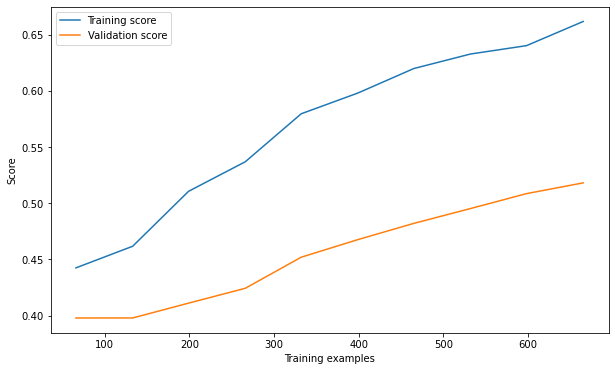

In [15]:
# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


With an accuracy score of .78, and a high mean accuracy of .95 across subsets of the data from cross validation, this suggests that the model is performing well. The training score is steadily increasing, showing that the model is able to learn complex patterns in the training data. The testing score is also steadily increasing, showing the model is also generalizing well to the testing set.However, there is still a significant gap between the two scores, showing that the model may be overfitting. 

We will try to improve performance by using ensemble methods. Ensemble methods are a type of learning in which multiple base models are trained independently in parallel on different subsets of the training data. Here, we will use Bagging Classifier because of its ability to reduce overfitting of data.



# Model 2- Bagging Classifier

In [33]:
model = BaggingClassifier(estimator=MultinomialNB(), n_estimators=10, random_state=42)
model.fit(X_resampled, y_resampled)


#Model evaluation
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))


Accuracy: 0.76
                      precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       1.00      0.50      0.67         4
       Cybersecurity       0.71      0.62      0.67         8
        Data Science       0.96      0.79      0.86        89
              DevOps       0.50      0.75      0.60         8
          Enrollment       0.55      0.79      0.65        14
       Miscellaneous       0.68      0.58      0.62        33
  Mobile Development       0.40      0.67      0.50         9
Software Engineering       0.63      0.86      0.73        22
               UI/UX       0.93      0.93      0.93        14

            accuracy                           0.76       208
           macro avg       0.74      0.75      0.72       208
        weighted avg       0.80      0.76      0.77       208



The clasisifer is performing worse than the Multinomial Naive Bayes model. 